# Baseline Models

In this notebook we will train a number of classic classification models on our dataset.
The models we will run will be
- Logistic Regression
- Stochastic Gradient Descent
- Naive Bayes
- Decision Trees
- Random Forest

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Import Scipy Models
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Train/Test Split

First we will define our features that we chose based on findings in the exploratory analysis.
The features we will use are:
- Age
- Booking Window Days
- Hipertension
- Scholarship
- Diabetes
- Handcap
- SMS Received
- Scheduled House
- Appointment Day of Week
- Percentage of previous no-shows for the patient ("No-show_user_mean")
- Percentage of previous no-shows for the patients neighbourhood ("No-show_neighbourhood_mean")
- Total number of previous no-shows for the patient ("No-show_sum")

In [2]:
data = pd.read_csv('../data/clean_data.csv')

_FEATURES = ['Age', 'booking_window_days', 'Hipertension', 'Scholarship', 
             'Diabetes', 'Handcap', 'SMS_received', 'ScheduledHour', 
             'AppointmentDayOfWeek']
_TARGET = 'No-show'

A number of the features can only be generated on the train_test split has taken place because they rely on a patients history. These features are:
- Percentage of previous no-shows for the patient ("No-show_user_mean")
- Percentage of previous no-shows for the patients neighbourhood ("No-show_neighbourhood_mean")
- Total number of previous no-shows for the patient ("No-show_sum")

Therefore we need to create these features within the train/test split method.

In [3]:
def train_test_add_features(data):
    skf = StratifiedKFold(n_splits=2)

    X = data[_FEATURES].values 
    y = data[_TARGET].values 

    for train_index, test_index in skf.split(X, y):
        # Calculate the user history
        train = data.iloc[train_index]
        train = train.join(train.groupby('PatientId')['No-show'].agg(np.mean), on='PatientId', rsuffix='_user_mean')
        train = train.join(train.groupby('Neighbourhood')['No-show'].agg(np.mean), on='Neighbourhood', rsuffix='_neighbourhood_mean')
        train = train.join(train.groupby('PatientId')['No-show'].agg('sum'), on='PatientId', rsuffix='_sum')
        #train = train.join(train.groupby('PatientId')['Age'].count(), on='PatientId', rsuffix='_count')
        
        test = data.iloc[test_index]
        
        test = pd.merge(test, train[['PatientId', 'No-show_user_mean']], on='PatientId', how='left') 
        test.at[test['No-show_user_mean'].isna(), 'No-show_user_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_neighbourhood_mean']], on='PatientId', how='left') 
        test.at[test['No-show_neighbourhood_mean'].isna(), 'No-show_neighbourhood_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_sum']], on='PatientId', how='left')
        test.at[test['No-show_sum'].isna(), 'No-show_sum'] = 0
        
        #test = pd.merge(test, train[['PatientId', 'Age_count']], on='PatientId', how='left')
        #test.at[test['Age_count'].isna(), 'Age_count'] = 0
        
        X_train = train[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_train = train[_TARGET].values
        
        X_test = test[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_test = test[_TARGET].values
        
        break

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_add_features(data)


## Models

We will now run through a number of models (with the default parameters) and judge their performance on the test set.

### Logistic Regression

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9259842756882393
Precision: 0.932359
Recall: 0.925984


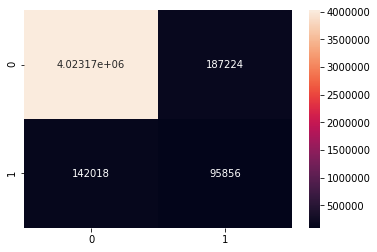

In [4]:
lr = LogisticRegression(random_state=0, class_weight='balanced')
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: %f' % (precision))
print('Recall: %f' % (recall))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

The logistic regression model is achieving a relatively high score, however the confusion matrix still shows us that the model is in general over guessing the false `No-show` class. This could be helped with hyperparameter optimsation.

### Stochastic Gradient Descent (SGD)

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.924648026165672
Precision: 0.933524
Recall: 0.924648


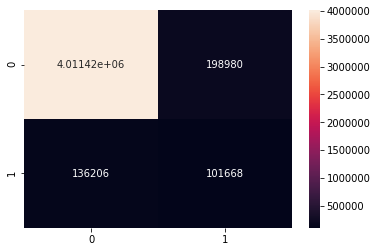

In [5]:
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5, class_weight='balanced')
sgd.fit(X_train, y_train)
print(sgd.score(X_test, y_test))

y_pred = sgd.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: %f' % (precision))
print('Recall: %f' % (recall))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

This SGD model also performs relatively well however it also over guesses the false `No-show` class meaning the accuracy for predicting a true `No-show` is ~50%.

### Naive Bayes

0.9296501944238559
Precision: 0.931542
Recall: 0.929650


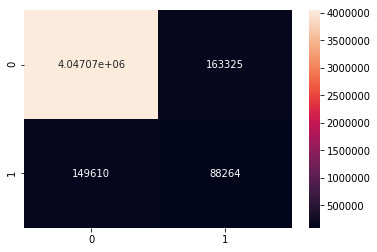

In [6]:
naive = GaussianNB()
naive.fit(X_train, y_train)
print(naive.score(X_test, y_test))

y_pred = naive.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: %f' % (precision))
print('Recall: %f' % (recall))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

We can see from the confusion matrix here that the model is over guessing the false `No-show` class and achieves a score similar to the other models.

### Decision Trees

0.9042322286569321
Precision: 0.928757
Recall: 0.904232


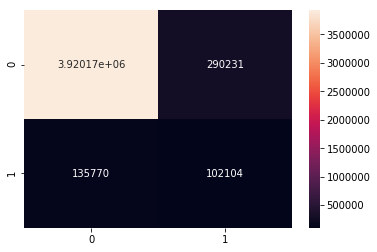

In [7]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

y_pred = dt.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: %f' % (precision))
print('Recall: %f' % (recall))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

This decision tree model performs slightly worse than the other baselines tried. We can also see that it is over predicting the false `No-show` class. This is likely due to outliers in the data.

### Random Forrest Classifier

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9229329777794564
Precision: 0.929450
Recall: 0.922933


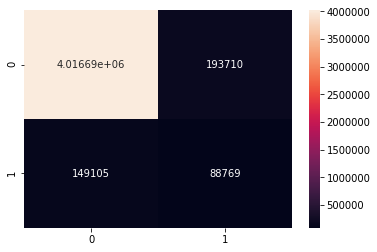

In [8]:
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Precision: %f' % (precision))
print('Recall: %f' % (recall))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

This random forest model performs slightly better than the decision tree. We can also see that it is over predicting the false `No-show` class. This is likely due to outliers in the data.

## Results

Based on the above results we have decided to take the Logistic Regression and Stochastic Gradient Descent models further for hyperparameter tuning.